## 6.6 卷积神经网络(LeNet)

LeNet于1989年发布，是最早发布的卷积神经网络之一。

### 6.6.1 LeNet

其组成如下：

- 卷积编码器：由两个卷积层组成
- 全连接层密集块，由3个全连接层组成

模型架构如下所示。

![](../images/6-6-1.svg)

下面使用了一个简单代码便可以实现LeNet。

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10),
)

上述代码去掉了最后一层的高斯激活，简化了一下。

下面将一个$28\times 28$的单通道黑白输入通过LeNet，通过打印每一层的输出形状，检查其是否于下图一致。

![](../images/6-6-2.svg)

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shpae: \t', X.shape)

Conv2d output shpae: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shpae: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shpae: 	 torch.Size([1, 6, 14, 14])
Conv2d output shpae: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shpae: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shpae: 	 torch.Size([1, 16, 5, 5])
Flatten output shpae: 	 torch.Size([1, 400])
Linear output shpae: 	 torch.Size([1, 120])
Sigmoid output shpae: 	 torch.Size([1, 120])
Linear output shpae: 	 torch.Size([1, 84])
Sigmoid output shpae: 	 torch.Size([1, 84])
Linear output shpae: 	 torch.Size([1, 10])


### 6.6.2 模型训练

在Fashion-MNIST上试一试

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

计算成本太高了，用GPU。

同时也要对`evaluate_accuracy`进行一定的更改。

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

不过在进行正向传播和反向传播之前，我们都需要将每一小批量数据移动到指定设备上。

在下面的训练中，也将使用交叉熵和小批量随机梯度下降。

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        """对全连接层和卷积层采用Xavier初始化"""
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = (torch.optim.SGD(net.parameters(), lr=lr))
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(
        xlabel = 'epoch',
        xlim=[1, num_epochs],
        legend=['train loss', 'train acc', 'test acc']
    )
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (train_l, train_acc, None),
                )
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(
            epoch + 1, 
            (None, None, test_acc),
        )
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

下面开始训练和评估

loss 0.465, train acc 0.826, test acc 0.807
84080.2 examples/sec on cuda:3


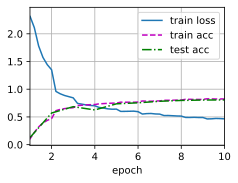

In [6]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 6.6.3 小结

- 卷积神经网络（CNN）是一类使用卷积层的网络。
- 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。
- 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
- 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
- LeNet是最早发布的卷积神经网络之一。